In [1]:
# Cleaning Ground Truth
import re
from pathlib import Path
import werpy
import jiwer
import pandas as pd
import os
import torch
import librosa
import soundfile as sf
import warnings
import numpy
warnings.filterwarnings("ignore", category=FutureWarning, module="whisper")
import faster_whisper
from faster_whisper import WhisperModel, BatchedInferencePipeline, decode_audio
import pickle
import numpy as np
from dataclasses import dataclass
from typing import List, Sequence

def clean_transcript(text):
    # Replace speaker identifiers
    # text = text.replace("INV1: ", "").replace("INV2: ", "").replace("PAR: ", "").replace("INV: ", "")
    
    # Replace basic formatting
    text = text.replace("‡", "")
    
    # Remove annotations like [+ gram], [+ exc], etc.
    text = re.sub(r'\[\+\s*[^\]]*\]', '', text)
    
    # Remove timing markers like (..), (.), (...)
    text = re.sub(r'\(\.\.\.\)|\(\.\.\)|\(\.\)', ' ', text)
    text = re.sub(r'\(\.+\)', '', text)  # More general pattern for (.), (..), (...)
    
    # Remove phonetic transcriptions like [: word]
    text = re.sub(r'\[:\s*[^\]]*\]', '', text)
    
    # Remove error codes like [* p:w], [* m:=ed], etc.
    text = re.sub(r'\[\*\s*[^\]]*\]', '', text)
    
    # Remove repetition markers like [/], [//]
    text = re.sub(r'\[\/\/?\]', '', text)
    
    # Remove pointing notes like &+points:picture
    text = re.sub(r'&\+points:[^\s]*', '', text)
    
    # Remove speech markers like &-, &+, +<, +/, +...
    text = re.sub(r'&[\+\-][a-z]*|\+[<\/]\s*|\+\.\.\.', '', text)
    
    
    # Remove special markers for retracings
    text = re.sub(r'\[\*\s*s:r:gc:pro-ret\]', '', text)
    
    # Remove 0det markers
    text = re.sub(r'0det\s*', '', text)
    
    # Clean up special characters
    text = re.sub(r'@q', '', text)
    text = re.sub(r'@l', '', text)
    
    # Remove sections in angle brackets that are immediately followed by corrections
    text = re.sub(r'<[^>]*>\s*\[\/{1,2}\]', '', text)
    
    # Fix contractions that were separated like (a)n(d)
    text = re.sub(r'\(a\)n\(d\)', 'and', text)
    text = re.sub(r'out_o\(f\)', 'out of', text)
    
    # Fix other common linguistic annotations
    text = re.sub(r'„', ',', text)

    
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    
    # Clean up turn-taking markers
    text = re.sub(r'\*+', '', text)
    
    text = text.lower()
    
    # Further clean-up from additional patterns
    text = text.replace("&-", "").replace("*", "").replace("<", "").replace(">", "")
    text = text.replace("[", "").replace("]", "").replace("/", "")
    text = text.replace("+", "").replace("...", "").replace("..", "").replace("()", "")
    text = text.replace("xxx", "").replace("(", "").replace(")", "").replace("_", " ")
    text = text.replace("mhm", "").replace("hm.", "").replace(" hm ", " ").replace(" uh"," ").replace(" huh"," ")
    text = text.replace("hmm", "").replace("mm", "").replace("www", " ").replace("-", " ")
    
    # Remove filler words
    text = re.sub(r'\b(um|uh)\b', '', text)
    
    # Remove gestures and non-verbal cues
    text = re.sub(r'&=[a-z]+(:[a-z]+)?', '', text)
    
    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase and trim
    
    text = text.strip()
    
    return text

In [56]:
import re
model_results = []
insertions_res = []
deletions_res = []
substitutions_res = []

model = ['gemini','large-FT-C', 'large-FT', 'large-V3C', 'large-V3', 'Base', 'BaseC']

for m in model:
    num_list = ["1713", "1554","1738","1944","1833","1731"]
    wer_list = []
    normal_wer = 0
    
    for num in num_list:
        print("Model: ", m, " patient: ", num)
        if m == 'gemini':
            path = f"Dataset/results/gemini_{num}.txt"
        elif m == 'large-FT-C':
            path = f"Dataset/results/largeFTC_{num}.txt"
        elif m == 'large-FT':
            path = f"Dataset/results/largeFT_{num}.txt"
        elif m == 'large-V3':
            path = f"Dataset/results/largeV3_{num}.txt"
        elif m == 'large-V3C':
            path = f"Dataset/results/largeV3C_{num}.txt"
        elif m == 'Base':
            path = f"Dataset/results/base_{num}.txt"
        elif m == 'BaseC':
            path = f"Dataset/results/baseC_{num}.txt"


        with open(f"Dataset/ground_truth/GT_{num}.txt", "r", encoding="utf-8") as file:

            ref = file.read().strip()
            ref = ref.replace("PAR:", "PAR1:")
            if num != "1554":
                ref = ref.replace("INV:", "INV1:")
            ref = clean_transcript(ref)
            reference = werpy.normalize(ref)


        with open(path, "r", encoding="utf-8") as file:
            hyp = file.read().strip()
            hyp = hyp.replace("-", " ")
            hyp = clean_transcript(hyp)
            hypothesis = werpy.normalize(hyp)
        

        marker_re = re.compile(r'^(?:inv|par)\d+$')
        tokens = reference.split()
        
        idx_dict = {}
        current_speaker = None
        word_idx = 0

        for tok in tokens:
            if marker_re.match(tok):
                current_speaker = tok
            else:
                word_idx += 1
                idx_dict[word_idx] = current_speaker
        reference = reference.replace("inv1","").replace("inv2","").replace("par1","")
        if num == '1738':
            print(reference)
        normal_sum = 0
        aphasia_sum = 0
        for i in idx_dict:
            if idx_dict[i] == 'par1':
                aphasia_sum += 1
            else:
                normal_sum += 1


        normal_err = 0
        aphasia_err = 0
        reference = reference.replace("  ", " ")
        ref_words = reference.split()
        hyp_words = hypothesis.split()

        deletions = []
        insertions = []
        substitutions = []
        substitutions_map = {}
        hyp_idx_err = []
        result = jiwer.process_words(reference, hypothesis)
        
        for alignment in result.alignments[0]:
            if alignment.type == 'delete':
                if idx_dict[alignment.ref_start_idx+1] == "par1":
                    for i in range(alignment.hyp_start_idx, alignment.hyp_end_idx + 1):
                        hyp_idx_err.append(i)
                    aphasia_err += (alignment.ref_end_idx - alignment.ref_start_idx) 
                    deletions.extend(ref_words[alignment.ref_start_idx:alignment.ref_end_idx])
                else:
                    normal_err += (alignment.ref_end_idx - alignment.ref_start_idx)
            elif alignment.type == 'substitute':
                if idx_dict[alignment.ref_start_idx+1] == "par1":
                    for i in range(alignment.hyp_start_idx, alignment.hyp_end_idx + 1):
                        hyp_idx_err.append(i)
                    aphasia_err += (alignment.ref_end_idx - alignment.ref_start_idx) 
                    words = (ref_words[alignment.ref_start_idx], hyp_words[alignment.hyp_start_idx])
                    substitutions_map[words] = (alignment.ref_start_idx, alignment.hyp_start_idx)
                    substitutions.append(words)
                else:
                    normal_err += (alignment.ref_end_idx - alignment.ref_start_idx)       
            elif alignment.type == 'insert':
                if idx_dict[alignment.ref_start_idx+1] == "par1":
                    for i in range(alignment.hyp_start_idx, alignment.hyp_end_idx + 1):
                        hyp_idx_err.append(i)
                    aphasia_err += 1
                    word = hyp_words[alignment.hyp_start_idx:alignment.hyp_end_idx]
                    insertions.extend(word)
                

        # print("Deletions:", result.insertions / word_idx)
        # print("Insertions:", result.deletions / word_idx)
        # print("Substitutions:", result.substitutions/ word_idx)
        insertions_res.append(result.insertions/word_idx)
        deletions_res.append(result.deletions/word_idx)
        substitutions_res.append(result.substitutions/word_idx)
 
        print("Aphasia_WER:", aphasia_err / aphasia_sum )

        normal_del = result.deletions - len(deletions)
        normal_ins = result.insertions - len(insertions)
        normal_sub = result.substitutions - len(substitutions)
        print("Normal_WER: ", normal_err / normal_sum )

        wer_list.append(aphasia_err / aphasia_sum)
        normal_wer += normal_err / normal_sum 
        

    normal_wer = normal_wer / 6
    wer_list.append(normal_wer)
    model_results.append(wer_list)
    
for i,m in enumerate(model):
    print(m)
    print(model_results[i])

Model:  gemini  patient:  1713
Aphasia_WER: 0.07219031993437244
Normal_WER:  0.09876543209876543
Model:  gemini  patient:  1554
Aphasia_WER: 0.13100848256361922
Normal_WER:  0.038381742738589214
Model:  gemini  patient:  1738
 so okay  so first im just gonna be asking you to do some talking  okay  so how do you think your speech is these days  very əræʃɪku  im close to ten years since the stroke  and ive been more or less talking for the last seven  and at times this tenth year i can wake up and feel fine and pronounce things very carefully  other the times im off in the somewhere about back and forth more than others past years  so anything else  yeah sure  so do you remember when you had your stroke  yeah  could you tell me about it  its late in december  i was alone in my small house  behind my a friend from my dɔrɚzu  and i sʌdəniu went  i would say at this point ill say blank  but going back as far beyond this i couldnt get a hold f myself  and i was in the house  i was very cold 

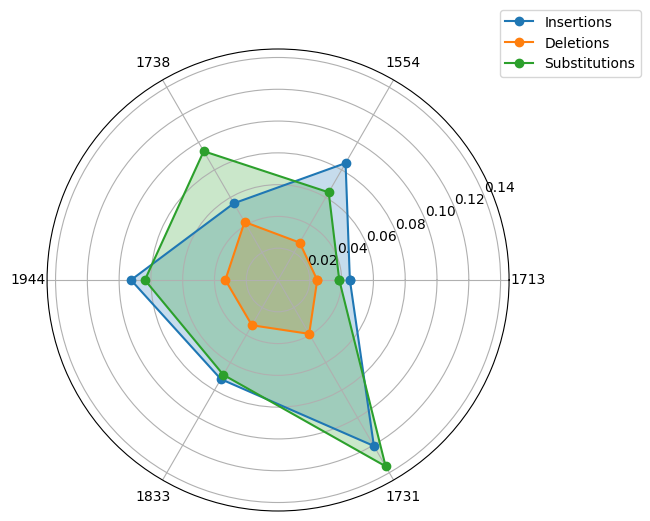

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Categories (audio file numbers) and data
num_list = ['1713', '1554', '1738', '1944', '1833', '1731']


# Number of variables
N = len(num_list)

# Compute angles for each category on the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
# Close the loop by appending the first angle again
angles += angles[:1]

# Append first data point to the end of each list to close the polygon
ins_values = insertions_res[:6] + insertions_res[:1]
del_values = deletions_res[:6] + deletions_res[:1]
sub_values = substitutions_res[:6] + substitutions_res[:1]

# Create the radar (spider) chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one line per metric
ax.plot(angles, ins_values,    marker='o', label='Insertions')
ax.plot(angles, del_values,    marker='o', label='Deletions')
ax.plot(angles, sub_values,    marker='o', label='Substitutions')

# Fill the area under each line (optional)
ax.fill(angles, ins_values,    alpha=0.25)
ax.fill(angles, del_values,    alpha=0.25)
ax.fill(angles, sub_values,    alpha=0.25)

# Set category labels at the correct angles
ax.set_xticks(angles[:-1])
ax.set_xticklabels(num_list)

# Set the range of the radial axis if desired
max_value = max(max(insertions_res[:6]), max(deletions_res[:6]), max(substitutions_res[:6]))
ax.set_ylim(0, max_value + 0.01 )

# Add a legend and title
ax.set_title("", y=1.10)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [3]:
import pandas as pd


# Provided num_list and wer_list
num_list = ['1713', '1554', '1738', '1944', '1833', '1731', 'normal']

# Create a DataFrame from the provided lists
df = pd.DataFrame({'Number': num_list, 'gemini': model_results[0], 'whisper': model_results[1]})

# Sort the DataFrame by 'Number' to match the order in the image (optional, but good for comparison)
# If you want to maintain the order of num_list, skip this sort.

df['Number'] = df['Number'].astype(str) # Convert back to string if you prefer

# Format the 'gemini' column to two decimal places
df['gemini'] = df['gemini'].apply(lambda x: f'{100*x:.3f}')
df['whisper'] = df['whisper'].apply(lambda x: f'{100*x:.3f}')

df

IndexError: list index out of range

In [4]:
num_list = ['1554']
for num in num_list:
    folder_path = f'Dataset/{num}_whisper'
    wav_count = sum(1 for file in os.listdir(folder_path) if file.endswith('.pkl'))
    word_list = []
    for chunk_num in range(1, wav_count+1):
        with open(f'Dataset/{num}_whisper/{chunk_num:03}.pkl', 'rb') as f:
            words = pickle.load(f)
            for w in words:
                word_list.append([w.word,w.probability])


In [6]:
hyp_with_prob = []
hyp_list = hypothesis.split()
for h in hyp_list:
    for w in word_list:
        current_word = werpy.normalize(w[0].strip().lower().replace("-",""))
        if current_word == h:
            hyp_with_prob.append([h, w[1]])  # record first probability
            break                            # bail out after the first hit
for i in range(1793):
    print(hyp_with_prob[i])
    if hyp_with_prob[i][0] != hyp_list[i]:
        print(hyp_list[i])

['so', 0.48828125]
['im', 0.9443359375]
['just', 0.91650390625]
['gonna', 0.6044921875]
['be', 0.90673828125]
['asking', 0.91259765625]
['you', 0.92724609375]
['to', 0.819580078125]
['do', 0.89208984375]
['some', 0.849609375]
['talking', 0.91650390625]
['okay', 0.68798828125]
['so', 0.48828125]
['how', 0.71875]
['do', 0.89208984375]
['you', 0.92724609375]
['think', 0.85205078125]
['your', 0.8583984375]
['speech', 0.76123046875]
['is', 0.95068359375]
['these', 0.74609375]
['days', 0.8681640625]
['its', 0.9716796875]
['good', 0.9404296875]
['but', 0.9423828125]
['will', 0.295166015625]
['be', 0.90673828125]
['better', 0.9072265625]
['i', 0.8125]
['can', 0.95458984375]
['little', 0.8408203125]
['i', 0.8125]
['can', 0.95458984375]
['read', 0.951171875]
['a', 0.9931640625]
['little', 0.8408203125]
['bit', 0.8154296875]
['i', 0.8125]
['have', 0.95361328125]
['trouble', 0.92236328125]
['with', 0.908203125]
['and', 0.299560546875]
['and', 0.299560546875]
['the', 0.718017578125]
['and', 0.29956

In [7]:
max(hyp_idx_err)

1958

In [8]:
len(hyp_with_prob)

1971

[['and', 0.299560546875], ['and', 0.299560546875], ['all', 0.1961669921875], ['it', 0.96337890625], ['i', 0.8125], ['week', 0.7919921875], ['a', 0.9931640625], ['speech', 0.76123046875], ['it', 0.96337890625], ['was', 0.953125], ['spring', 0.7216796875], ['tuesday', 0.56103515625], ['wednesday', 0.2802734375], ['following', 0.308349609375], ['know', 0.461669921875], ['doctors', 0.295654296875], ['wow', 0.1568603515625], ['dress', 0.1368408203125], ['so', 0.48828125], ['so', 0.48828125], ['i', 0.8125], ['watched', 0.486572265625], ['my', 0.8681640625], ['i', 0.8125], ['dusting', 0.774658203125], ['i', 0.8125], ['wanna', 0.455078125], ['talk', 0.89892578125], ['talk', 0.89892578125], ['staying', 0.822265625], ['when', 0.9736328125], ['when', 0.9736328125], ['well', 0.55517578125], ['exc', 0.291748046875], ['excited', 0.6083984375], ['three', 0.1845703125], ['watched', 0.486572265625], ['movies', 0.87890625], ['hes', 0.4234619140625], ['google', 0.53173828125], ['oh', 0.95947265625], ['sp

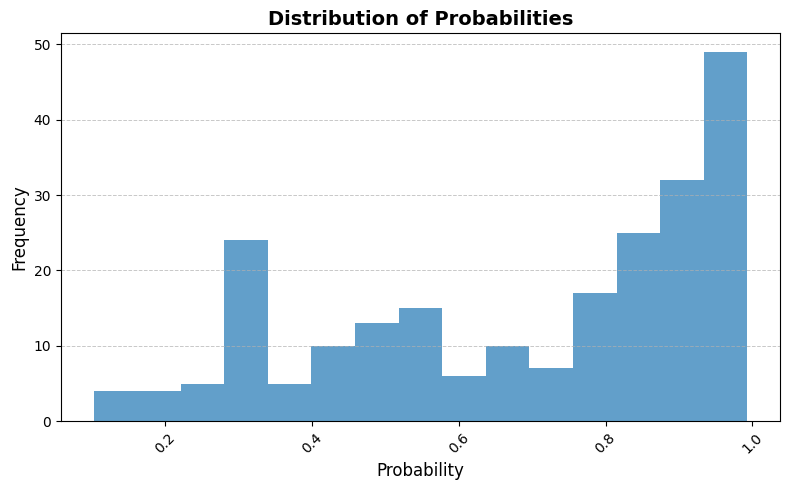

In [9]:
import matplotlib.pyplot as plt

data = []
for idx in hyp_idx_err:
    data.append(hyp_with_prob[idx])
print(data)
# Extract values
values = [item[1] for item in data]

# Create a larger figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histogram with more bins, semi-transparent bars
ax.hist(values, bins=15, alpha=0.7)

# Beautify axes
ax.set_xlabel('Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Probabilities', fontsize=14, fontweight='bold')

# Add horizontal grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve tick label readability
ax.tick_params(axis='x', rotation=45)

# Tight layout for clean spacing
plt.tight_layout()
plt.show()

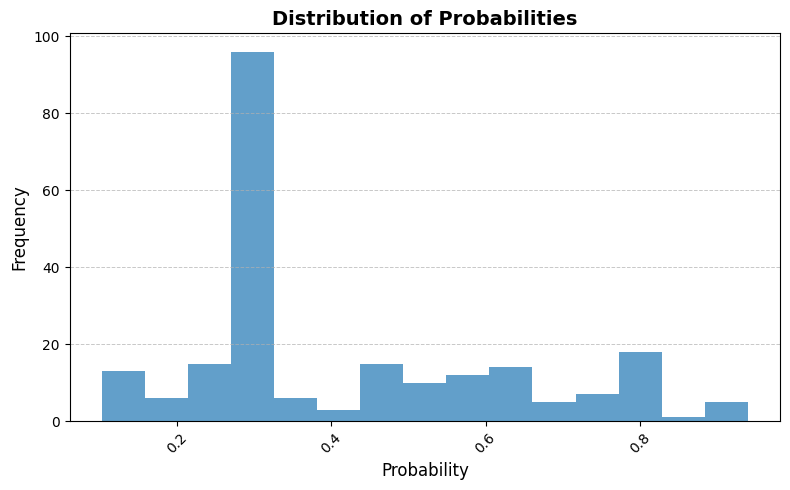

In [11]:
data = []
for idx in hyp_idx_err:
    if idx+1 == len(hyp_with_prob) or idx-1 <= 0 or idx+2 == len(hyp_with_prob):
        continue

    data.append([hyp_with_prob[idx][0],min(hyp_with_prob[idx-2][1], hyp_with_prob[idx-1][1], hyp_with_prob[idx][1], hyp_with_prob[idx+1][1] , hyp_with_prob[idx+2][1])])
# Extract values
values = [item[1] for item in data]

# Create a larger figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histogram with more bins, semi-transparent bars
ax.hist(values, bins=15, alpha=0.7)

# Beautify axes
ax.set_xlabel('Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Probabilities', fontsize=14, fontweight='bold')

# Add horizontal grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve tick label readability
ax.tick_params(axis='x', rotation=45)

# Tight layout for clean spacing
plt.tight_layout()
plt.show()

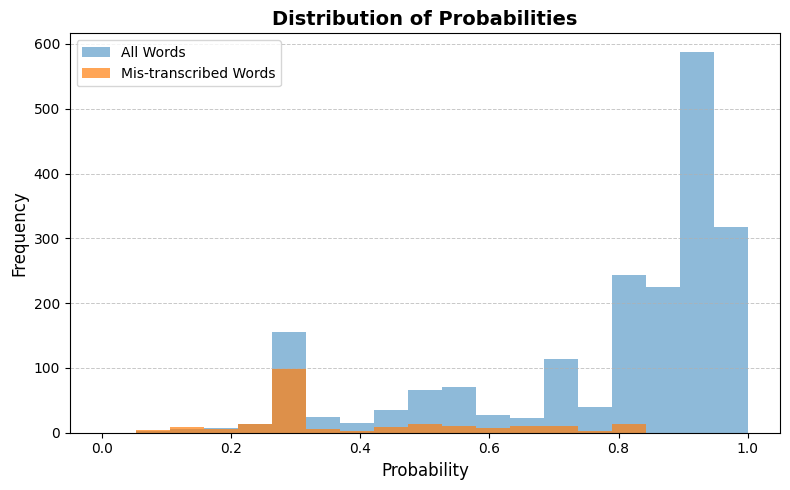

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- build your two datasets ---

# 1) filtered values (your original selection logic)
filtered = []
for idx in hyp_idx_err:
    if idx+1 == len(hyp_with_prob) or idx-1 <= 0 or idx+2 == len(hyp_with_prob):
        continue
    # skip runs where everything is already very high
    if min(hyp_with_prob[idx-1][1], hyp_with_prob[idx][1], hyp_with_prob[idx+2][1]) > 0.9:
        continue
    # take the minimum over a window of five
    mn = min(
        hyp_with_prob[idx-2][1],
        hyp_with_prob[idx-1][1],
        hyp_with_prob[idx][1],
        hyp_with_prob[idx+1][1],
        hyp_with_prob[idx+2][1]
    )
    filtered.append(mn)

# 2) full distribution of all probabilities
all_vals = [p for _, p in hyp_with_prob]

# --- choose common bin edges ---
bins = np.linspace(0, 1, 20)  # e.g. 20 bins between 0 and 1

# --- plotting ---
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(all_vals,   bins=bins, alpha=0.5, label='All Words')
ax.hist(filtered,   bins=bins, alpha=0.7, label='Mis-transcribed Words')

ax.set_xlabel('Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Probabilities', fontsize=14, fontweight='bold')

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


In [75]:
# --- data model ---------------------------------------------------------------
@dataclass
class Word:
    start: float
    end: float
    word: str
    probability: float  # 0‒1 range


# --- robust word-level anomaly detector ---------------------------------------
def robust_logprob_threshold(logps: Sequence[float], k: float = 2.5) -> float:
    """
    Compute a *lower* threshold on log-probs using Median ± k·MAD.
    Words whose log-p < threshold are flagged as anomalies.

    Parameters
    ----------
    logps : 1-D iterable of per-word ln(probability)
    k     : how many "robust σ" below the median to cut off. 2.5‒3 ≈ 99 % conf.
    """
    logps = np.asarray(logps)
    med = np.median(logps)
    mad = np.median(np.abs(logps - med)) * 1.4826  # convert MAD→σ
    return med - k * mad


def flag_anomalous_words(segment: List[Word], k: float = 2.5) -> List[Word]:
    """
    Return the list of Word objects whose confidence is anomalously low
    relative to the rest of *this* segment.
    """
    logps = [np.log(max(w.probability, 1e-12)) for w in segment]
    thr = robust_logprob_threshold(logps, k)
    return [w for w, lp in zip(segment, logps) if lp < thr]



for num in num_list:
    folder_path = f'Dataset/{num}_whisper'
    wav_count = sum(1 for file in os.listdir(folder_path) if file.endswith('.pkl'))
    for chunk_num in range(1, wav_count+1):
        with open(f'Dataset/{num}_whisper/{chunk_num:03}.pkl', 'rb') as f:
            words = pickle.load(f)
            anomalies = flag_anomalous_words(words, k=1.5)
            print([(w.word.strip(), w.probability) for w in anomalies])


[('So', 0.48828125), ('gonna', 0.6044921875), ('Okay.', 0.68798828125), ('how', 0.71875), ('Mm,', 0.1995849609375), ('um...', 0.4840087890625), ('uh...', 0.5841064453125)]
[('will', 0.295166015625), ('Um', 0.43603515625)]
[('um', 0.40380859375), ('uh', 0.298583984375), ('and', 0.299560546875), ('.', 0.20068359375)]
[('all', 0.1961669921875), ('that.', 0.5615234375), ('mhm', 0.4393310546875), ('mhm', 0.740234375), ('.', 0.54736328125), ('mhm', 0.601318359375), ('.', 0.748046875), ('uh', 0.281982421875), ('do', 0.49267578125), ('mhm', 0.712158203125), ('um', 0.4912109375), ('tell', 0.7985026041666666), ('well', 0.55517578125), ('um', 0.71435546875), ('.', 0.310546875)]
[('and', 0.7353515625), ('um', 0.45654296875), ('and', 0.5654296875), ('um', 0.484130859375)]
[('I', 0.457275390625), ('it.', 0.529296875), ('I', 0.5361328125)]
[('What', 0.358642578125), ('the', 0.50830078125), ('I', 0.5498046875), ('Yeah.', 0.70849609375)]
[('So', 0.35791015625), ('what', 0.525390625), ('to', 0.501464843

/home/arsalan77x/Whisper/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/arsalan77x/Whisper/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [75]:
def compute_metrics(tp, fp, tn, fn):
    """
    Calculate Precision, Recall, and F1 Score from TP, FP, TN, FN.

    Parameters:
    - tp: True Positives
    - fp: False Positives
    - tn: True Negatives (not used here, but included for completeness)
    - fn: False Negatives

    Returns:
    - precision, recall, f1_score
    """
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score  = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1_score


# Example usage
tp, fp, tn, fn = 113, 94, 0, 12  # from your table
precision, recall, f1 = compute_metrics(tp, fp, tn, fn)
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


Precision: 0.546
Recall:    0.904
F1 Score:  0.681


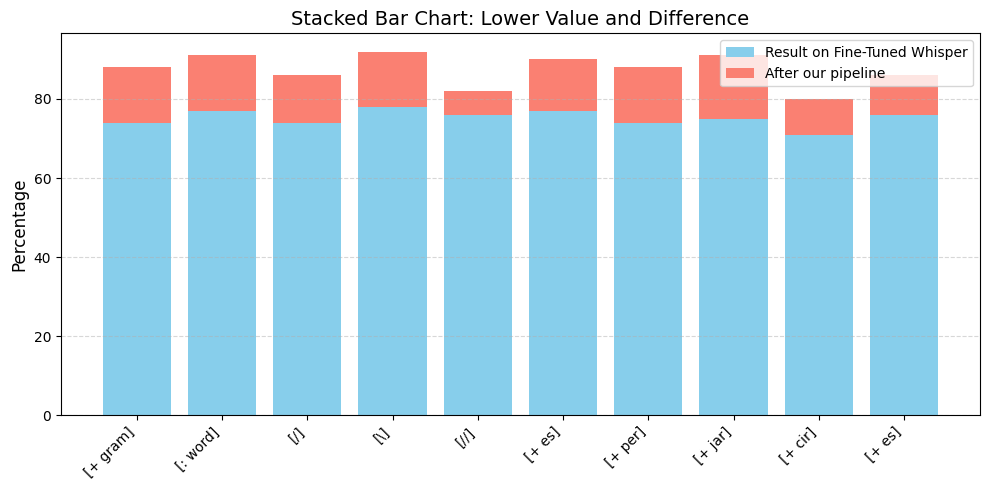

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Your data: replace these with your real values ---
categories = ["[+ gram]", "[: word]", "[/]", "[\\]", "[//]",
              "[+ es]", "[+ per]", "[+ jar]", "[+ cir]", "[+ es]"]
lower_vals   = [74, 77, 74, 78, 76, 77, 74, 75, 71, 76]
diff_to_high = [14, 14, 12, 14,  6, 13, 14, 16,  9, 10]

# X positions
x = np.arange(len(categories))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x, lower_vals,
       label="Result on Fine-Tuned Whisper",
       color="skyblue")
ax.bar(x, diff_to_high,
       bottom=lower_vals,
       label="After our pipeline",
       color="salmon")

# Labels & title
ax.set_title("Stacked Bar Chart: Lower Value and Difference", fontsize=14)
ax.set_ylabel("Percentage", fontsize=12)

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")

# Legend
ax.legend(loc="upper right")

# Grid & layout
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()
